In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
filter_dir = './deploy/filter'
classification_dir = './deploy/classifier'

In [3]:
from data.dataset import AnnotatedData
from train import *
d = AnnotatedData.load('data/senna')

Couldn't import dot_parser, loading of dot files will not be possible.


In [15]:
import cPickle as pkl
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib
import matplotlib.pylab as P
import os
import json
from collections import Counter
import numpy as np
from pprint import pprint, pformat

def read_log(folder):
    with open(os.path.join(folder, 'train.log')) as f:
        logs = {}
        for l in f:
            d = json.loads(l.strip("\n"))
            for k, v in d.items():
                if k not in logs:
                    logs[k] = []
                logs[k] += [v]
    return logs

def read_args(folder):
    with open(os.path.join(folder, 'args.json')) as f:
        return json.load(f)

def read_test(folder):
    with open(os.path.join(folder, 'test.json')) as f:
        test = json.load(f)
    with open(os.path.join(folder, 'test.pkl')) as f:
        d = pkl.load(f)
    pred, targ = d['pred'], d['targ']
    
    counts = Counter(targ.tolist())
    order = np.array([e[0] for e in counts.most_common()])
    counts = np.array([e[1] for e in counts.most_common()])
    
    cm = confusion_matrix(targ, pred, order)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    f1_macro = f1_score(targ, pred, average='macro')
    f1_micro = f1_score(targ, pred, average='micro')
    return test, cm, counts, order, f1_macro, f1_micro

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


def plot_confusion_matrix(ax, cm, order, title='Confusion matrix', cmap=P.cm.Blues):
    names = [d.vocab['rel'].index2word[o] for o in order] if len(cm) > 2 else ['no_relation', 'relation']
    handle = ax.imshow(cm, interpolation='nearest', cmap=matplotlib.cm.Blues)
    ax.set_title(title)
    P.colorbar(handle, ax=ax)
    tick_marks = np.arange(len(names))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(names, rotation=90)
    ax.set_yticklabels(names)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
def print_experiment(e):
    args = read_args(e)
    logs = read_log(e)
    test, cm, counts, order, f1_macro, f1_micro = read_test(e)
    args.update(test)
    args.update({'f1_macro': f1_macro, 'f1_micro': f1_micro})
    
    fig, ax = P.subplots(3, figsize=(10, 30))
    
    desc = ax[0]
    conf = ax[1]
    acc = ax[2]
    
    desc.text(0.05, 0.95, pformat(args, indent=2), transform=desc.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
    
    plot_confusion_matrix(conf, cm, order)
    acc.plot(logs['train_f1'], label='train', color='b')
    acc.plot(logs['dev_f1'], label='dev', color='r')
    acc.set_ylabel('f1')
    acc.legend(loc='lower right')
    #     loss.plot(logs['train_loss'], label='train', color='b')
    #     loss.plot(logs['dev_loss'], label='dev', color='r')
    #     loss.set_ylabel('loss')
    #     loss.legend(loc='upper right')
    print 'processed', e

processed ./deploy/classifier


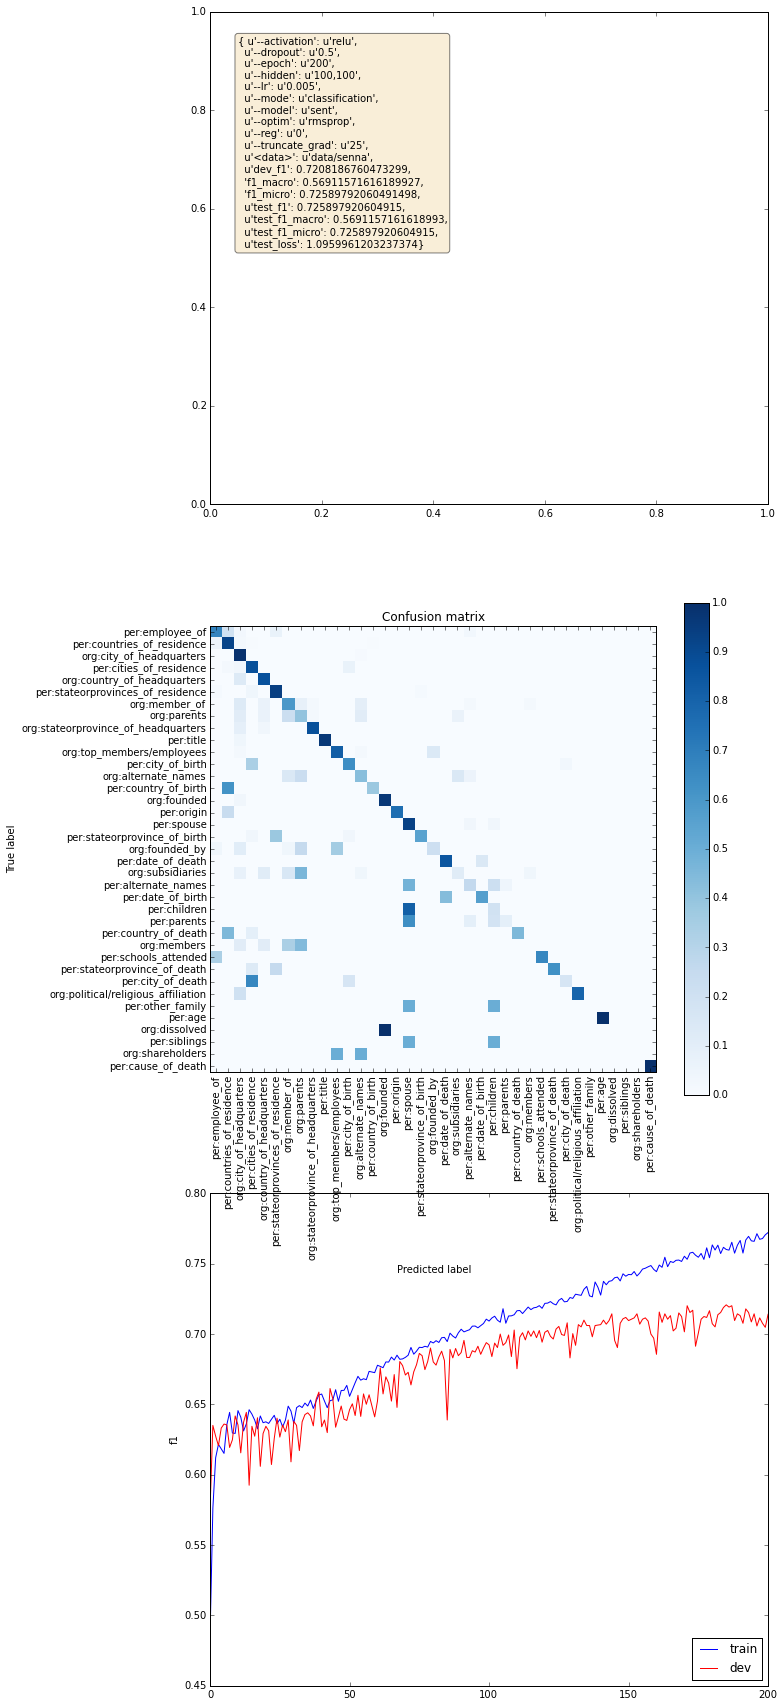

In [16]:
P.close('all')
print_experiment(classification_dir)

processed ./deploy/filter


/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:931: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:931: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


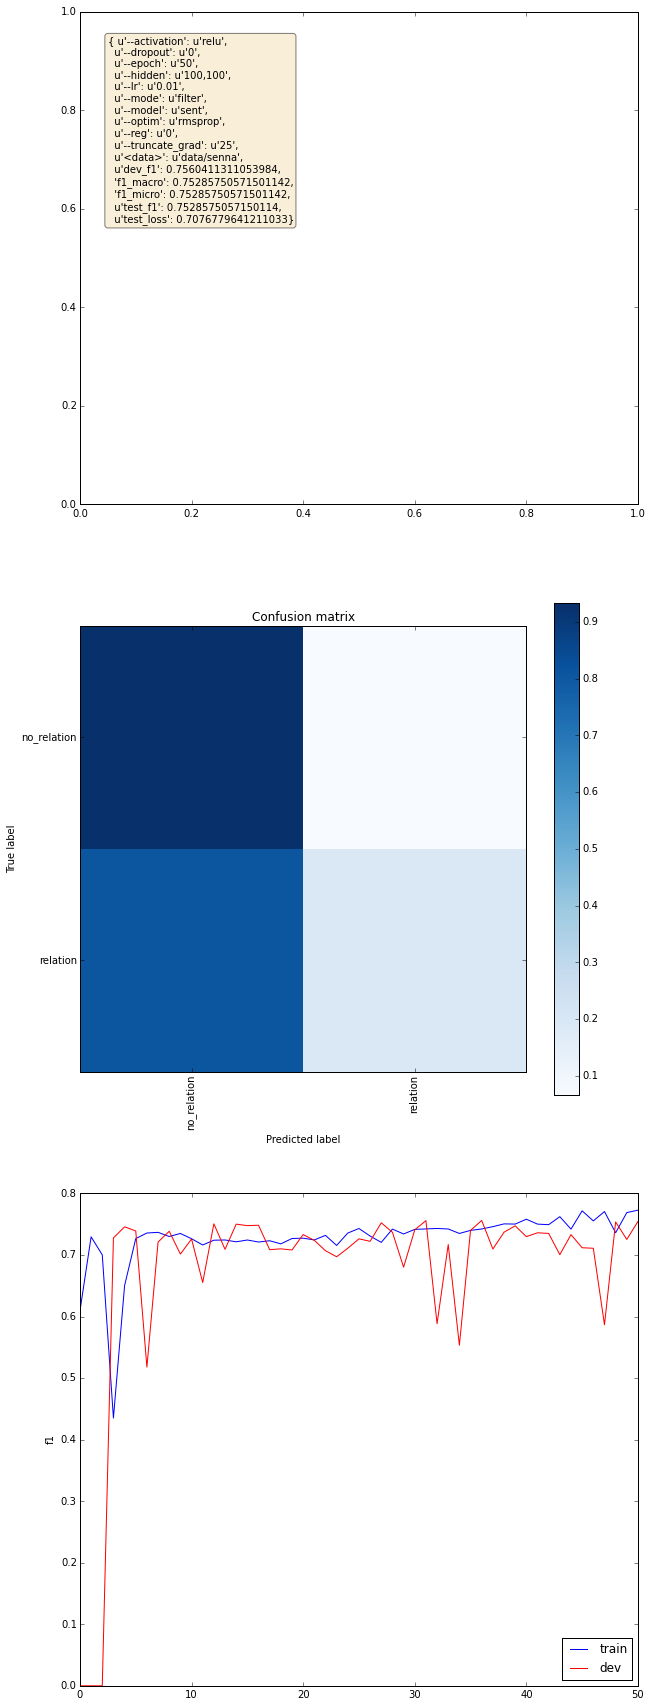

In [17]:
print_experiment(filter_dir)

In [22]:
typechecker = TypeCheckAdaptor(d.vocab)

def load_model(folder):
    with open(os.path.join(folder, 'args.json')) as f:
        args = json.load(f)
    with open(os.path.join(folder, 'model.weights.pkl')) as f:
        weights = pkl.load(f)
    model = get_model_from_arg(args, d, typechecker)
    model.set_weights(weights)
    return model
    
filter_model = load_model(filter_dir)
classi_model = load_model(classification_dir)

In [38]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from pprint import pprint

def get_XY(X, Y):
    Xwords, Xparse, Xner = X
    Xin = Xwords
    Yin = Y
    return Xin, Yin, Xner

def evaluate(filter_threshold):
    preds, targs = [], []
    for X, Y in d.generate_batches('test', label='raw'):
        Xin, Yin, Xner = get_XY(X, Y)
        classi_pred = classi_model.predict(Xin, verbose=0)
        classi_pred *= typechecker.get_valid_cpu(Xner[:, 0], Xner[:, 1])
        classi_pred = classi_pred.argmax(axis=1)
        
        filter_pred = filter_model.predict(Xin, verbose=0).flatten() > filter_threshold
        valid = typechecker.get_valid_cpu(Xner[:, 0], Xner[:, 1]).sum(axis=1) > 0
        filter_pred *= valid
        
        pred_invalid = filter_pred == 0
        classi_pred[pred_invalid] = d.vocab['rel']['no_relation']
        
        preds.append(classi_pred)
        targs.append(Y)
    preds = np.concatenate(preds).astype('int32')
    targs = np.concatenate(targs).astype('int32')
    
    f1, prec, rec = [f(targs, preds, average='micro') for f in [f1_score, precision_score, recall_score]]
    acc = accuracy_score(targs, preds)
    return {'f1':f1, 'precision':prec, 'recall':rec, 'accuracy':acc, 'preds':preds, 'targs':targs}

evaluate(0.5)

{'accuracy': 0.49361382419233657,
 'f1': 0.49361382419233657,
 'precision': 0.49361382419233657,
 'preds': array([11, 18,  6, ..., 24, 26,  5], dtype=int32),
 'recall': 0.49361382419233657,
 'targs': array([ 1, 18,  6, ...,  1, 26,  5], dtype=int32)}

In [42]:
best = None
for threshold in np.linspace(0.5, 0.9, 20):
    print 'threshold', threshold
    result = evaluate(threshold)
    if best is None or result['f1'] > best['f1']:
        best = result
    pprint(result)
print 'best:'
pprint(best)

threshold 0.5
{'accuracy': 0.49361382419233657,
 'f1': 0.49361382419233657,
 'precision': 0.49361382419233657,
 'preds': array([2, 5, 6, ..., 0, 3, 6], dtype=int32),
 'recall': 0.49361382419233657,
 'targs': array([1, 5, 1, ..., 0, 1, 1], dtype=int32)}
threshold 0.521052631579
{'accuracy': 0.49661908339594291,
 'f1': 0.49661908339594291,
 'precision': 0.49661908339594291,
 'preds': array([ 4, 11,  8, ...,  1,  1, 27], dtype=int32),
 'recall': 0.49661908339594291,
 'targs': array([4, 6, 8, ..., 2, 1, 7], dtype=int32)}
threshold 0.542105263158
{'accuracy': 0.5,
 'f1': 0.5,
 'precision': 0.5,
 'preds': array([12,  6,  0, ..., 11,  0,  8], dtype=int32),
 'recall': 0.5,
 'targs': array([ 2,  6,  0, ..., 11, 17,  8], dtype=int32)}
threshold 0.563157894737
{'accuracy': 0.50450788880540942,
 'f1': 0.50450788880540942,
 'precision': 0.50450788880540942,
 'preds': array([17,  6, 11, ...,  4,  9,  1], dtype=int32),
 'recall': 0.50450788880540942,
 'targs': array([3, 2, 1, ..., 4, 9, 1], dtype=int

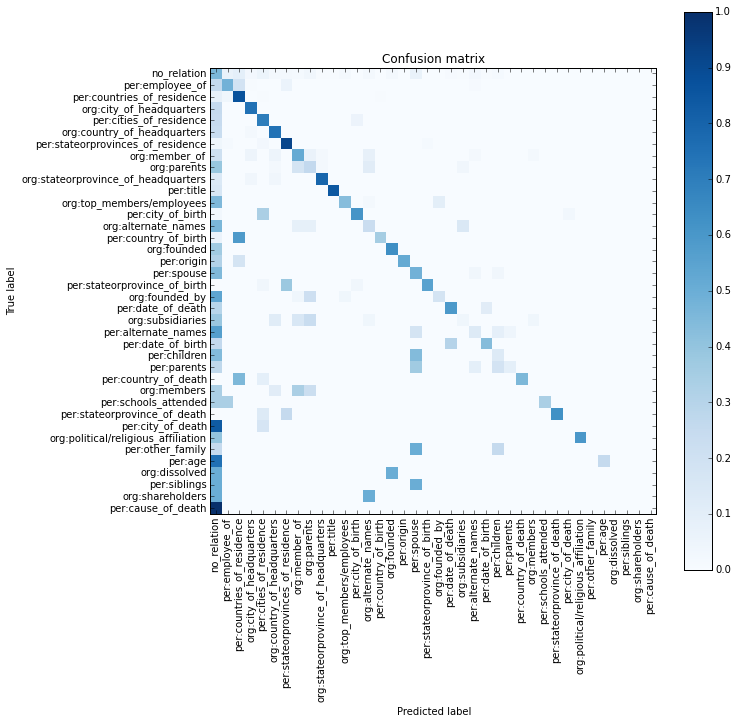

In [40]:
counts = Counter(best['targs'].tolist())
order = np.array([e[0] for e in counts.most_common()])
counts = np.array([e[1] for e in counts.most_common()])

cm = confusion_matrix(best['targs'], best['preds'], order)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = P.subplots(figsize=(10, 10))
plot_confusion_matrix(ax, cm, order, title='Confusion matrix', cmap=P.cm.Blues)